In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sayantikalaskar","key":"9c46cbc3dc0f3d53e9eef348359a288e"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d shubhamgoel27/dermnet

dermnet.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip dermnet.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keloids-8.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keloids-80.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keloids-9.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-100.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-101.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-102.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-103.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-104.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-105.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-106.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthom

In [ ]:
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

In [ ]:
data_path = '/content/train'

In [ ]:
train_data = []
val_data = []

for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    file = os.listdir(folder_path)
    num_train = int(0.8 * len(file))
    files_train = random.sample(file, num_train)
    files_val = list(set(file) - set(files_train))

    for file in files_train:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        train_data.append((img, folder))

    for file in files_val:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        val_data.append((img, folder))

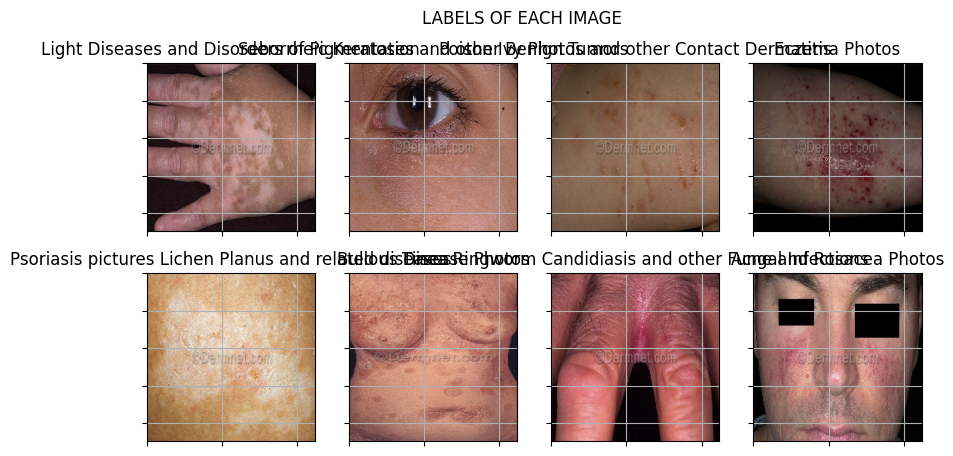

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
plt.suptitle('LABELS OF EACH IMAGE')

for (img, label), ax in zip(random.sample(train_data, 8), axes.flatten()):
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid(True)
    ax.set_title(label)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )

plt.show()

PREPARE MODEL

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
base_model.trainable = False

In [ ]:
num_classes = 23
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

PREPROCESS DATA

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

train_data = [(preprocess_input(input), label) for input, label in train_data]
val_data = [(preprocess_input(input), label) for input, label in val_data]

X_train, y_train = zip(*train_data)
X_val, y_val = zip(*val_data)

X_train = preprocess_input(np.array(X_train))
X_val = preprocess_input(np.array(X_val))

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

y_train_one_hot = to_categorical(y_train_encoded, num_classes)
y_val_one_hot = to_categorical(y_val_encoded, num_classes)

TRAIN

In [21]:
EPOCHS = 12
BATCH_SIZE = 32
history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot),
                   epochs = EPOCHS, batch_size=BATCH_SIZE)

model.save('/kaggle/working/my_model.h5')

Epoch 1/12
100/100 [==============================] - 722s 7s/step - loss: 2.7591 - accuracy: 0.2403 - val_loss: 2.5820 - val_accuracy: 0.2519
Epoch 2/12
100/100 [==============================] - 760s 8s/step - loss: 2.1345 - accuracy: 0.3694 - val_loss: 2.4321 - val_accuracy: 0.3049
Epoch 3/12
100/100 [==============================] - 709s 7s/step - loss: 1.8009 - accuracy: 0.4599 - val_loss: 2.4781 - val_accuracy: 0.3222
Epoch 4/12
100/100 [==============================] - 701s 7s/step - loss: 1.5397 - accuracy: 0.5326 - val_loss: 2.5925 - val_accuracy: 0.2975
Epoch 5/12
100/100 [==============================] - 763s 8s/step - loss: 1.2555 - accuracy: 0.6175 - val_loss: 2.5634 - val_accuracy: 0.3235
Epoch 6/12
100/100 [==============================] - 722s 7s/step - loss: 1.0420 - accuracy: 0.6883 - val_loss: 2.6794 - val_accuracy: 0.3160
Epoch 7/12
100/100 [==============================] - 762s 8s/step - loss: 0.7907 - accuracy: 0.7785 - val_loss: 2.7625 - val_accuracy: 0.3247

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


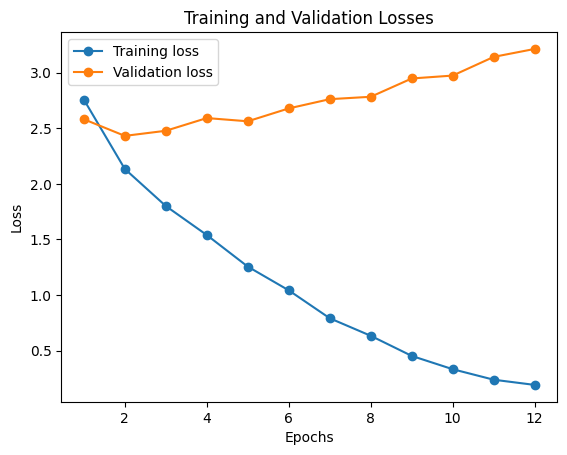

In [22]:
  # Get the training and validation losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create an array representing the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation losses
plt.plot(epochs, train_loss,label='Training loss', marker='o')
plt.plot(epochs, val_loss,label='Validation loss', marker='o')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

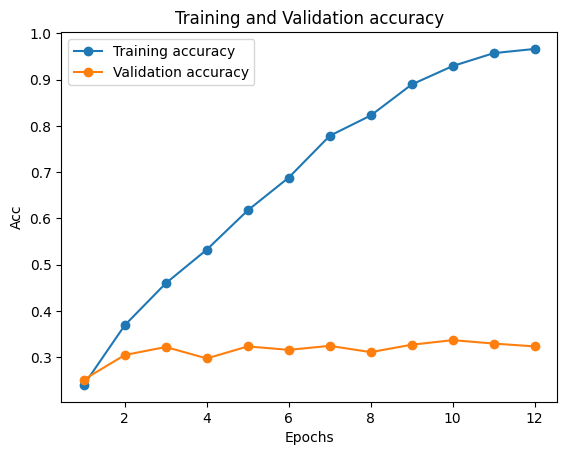

In [23]:
# Get the training and validation losses from the history object
train_loss = history.history['accuracy']
val_loss = history.history['val_accuracy']

# Create an array representing the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation losses
plt.plot(epochs, train_loss,label='Training accuracy', marker='o')
plt.plot(epochs, val_loss,label='Validation accuracy', marker='o')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

# Show the plot
plt.show()

PREDICT

In [24]:
from tensorflow.keras.models import load_model

In [25]:
test_path = '/content/test'

In [26]:
model = load_model('/kaggle/working/my_model.h5')

In [27]:
real_label = []
predicted_class = []

for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        img = preprocess_input(np.array([img]))  # Add an extra dimension for batching

        predictions = model.predict(img)
        real_label.append(folder)
        predicted_class_index = np.argmax(predictions)
        predicted_class.append(le.classes_[predicted_class_index])

1/1 [==============================] - 0s 183ms/step


In [28]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(real_label, predicted_class)

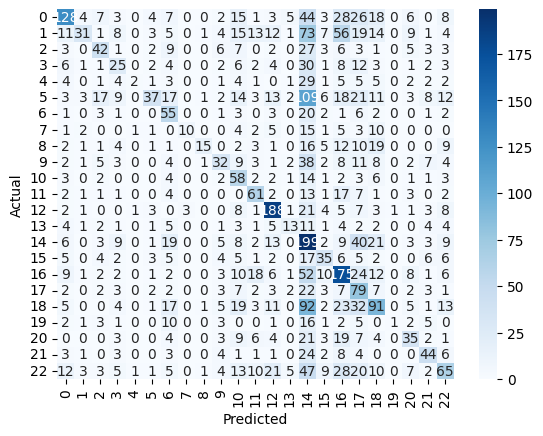

In [29]:
import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()